In [1]:
# Tang Kit Lim (WQD190032)

import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import distance
from pathlib import Path

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

preprocessed_township_csv = data_directory + 'edgeprop_townships_preprocessed.csv'
preprocessed_transaction_csv = data_directory + 'edgeprop_transactions_preprocessed.csv'
preprocessed_poi_csv = data_directory + 'iproperty_pois_preprocessed.csv'

transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

townships = pd.read_csv(preprocessed_township_csv, na_values=['None'], index_col=0)
transactions = pd.read_csv(preprocessed_transaction_csv, na_values=['None'], index_col=0)
pois = pd.read_csv(preprocessed_poi_csv, na_values=['None'], index_col=0)


## Merge Township dataset into Transaction dataset


In [3]:
# Merge using inner join, transactions without township information will be ignored

transactions = transactions.merge(townships, left_on='project_id', right_on='project_id', suffixes=('', '_township'))

## Data Cleaning


In [4]:
# create a backup in case need to redo processing
transactions_bk = transactions.copy()

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173218 entries, 0 to 173217
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   project_id                 173218 non-null  int64  
 1   project_name               173218 non-null  object 
 2   transacted_price           173218 non-null  int64  
 3   unit_price_psf             173193 non-null  float64
 4   date                       173218 non-null  int64  
 5   property_type              173218 non-null  object 
 6   tenure                     173218 non-null  object 
 7   floor                      73145 non-null   object 
 8   area_sqft                  173218 non-null  float64
 9   non_landed                 173218 non-null  int64  
 10  bedrooms                   173218 non-null  float64
 11  psf                        173218 non-null  float64
 12  price                      173218 non-null  int64  
 13  state                      17

In [6]:
# check similar features: 'psf' and 'unit_price_psf'
# transactions[(transactions['unit_price_psf'] != transactions['psf'])][['unit_price_psf', 'psf']].describe()
# 'psf' was recalculated during data preparation, keep 'psf' only, 'unit_price_psf' will be dropped


In [7]:
# check similar features 'transacted_price' and 'price'
transactions[(transactions['transacted_price'] != transactions['price'])][['transacted_price', 'price']].describe()
# 'transacted_price' and 'price' are identical, keep 'price' only, 'transacted_price' will be dropped

,transacted_price,price
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [8]:
# check similar features: 'state' and 'state_township'
transactions[(transactions['state'] != transactions['state_township'])][[
    'state', 'state_township', 'project_id', 'latitude', 'longitude'
]]
# 'state' and 'state_township' are almost identical, with few exceptions. 
# 'state_township' is more accurate based on the gps location
# 'state' will be dropped, keep 'state_township' and will be renamed to 'state'

,state,state_township,project_id,latitude,longitude
10218,Kuala Lumpur,Selangor,12192,3.081360,101.762001
10390,Kuala Lumpur,Penang,12374,5.356920,100.429001
16925,Kuala Lumpur,Perak,12752,4.598970,101.056000
53253,Selangor,Johor,13183,1.571710,103.611000
65008,Johor,Penang,17337,5.269977,100.471551
65009,Johor,Penang,17337,5.269977,100.471551
65010,Johor,Penang,17337,5.269977,100.471551
65011,Johor,Penang,17337,5.269977,100.471551
65012,Johor,Penang,17337,5.269977,100.471551
65013,Johor,Penang,17337,5.269977,100.471551


In [9]:
# check similar features: 'project_name' and 'township'
transactions[transactions['project_name'] != transactions['township']][['project_name', 'township']].drop_duplicates()
# 'township' will be dropped, keep 'project_name' and will be renamed to 'township'

,project_name,township
24103,Kemuning Avenue,KEMUNING AVENUE
59529,Damai Apartment,DAMAI APARTMENT
89797,Sentrovue,SENTROVUE
107110,Damai 88,DAMAI 88
110185,Mahkota Residensi,MAHKOTA RESIDENSI
116047,Temasya 8,TEMASYA 8
166689,Bangi Vista,BANGI VISTA
166925,Gugusan Kantan,GUGUSAN KANTAN
173082,Tiara Hill,TIARA HILL


## Add New Features

In [10]:
# extract year from epoch and store as new column
import time
transactions['year'] = transactions['date'].apply(
    lambda x: str(pd.Timestamp(x, unit='s')).split("-")[0]
)

## Handling Incorrect / Remaining Missing Data

In [11]:
# remove all transactions with gps coordination out of Malaysia
transactions = transactions[~(
    (transactions['latitude'] < 0.85) |
    (transactions['latitude'] > 7.4) |
    (transactions['longitude'] < 99.5) | 
    (transactions['longitude'] > 119.3) | 
    (pd.isna(transactions['latitude'])) |
    (pd.isna(transactions['longitude'])) 
)]


In [12]:
# drop rows without values for 'psf' or 'psf' = 0
transactions.dropna(subset = ['psf'], how = 'any', inplace = True)
transactions = transactions[~(transactions['psf'] < 1)]


In [13]:
# area (location of the transaction) & area_sqft (actualy area of the transaction in sqft) 
# could be confusing. Going to rename area as city.
transactions['area'].value_counts()

Johor Bahru    7985
Shah Alam      6290
Klang          5147
Kajang         4172
Puchong        4137
               ... 
Ampang            3
East Ledang       2
Paloh             2
Ipoh              1
Gemas             1
Name: area, Length: 273, dtype: int64

In [14]:
# area (location of the transaction) & area_sqft (actualy area of the transaction in sqft) 
# could be confusing. Going to rename area as city.
transactions['area'].value_counts()

Johor Bahru    7985
Shah Alam      6290
Klang          5147
Kajang         4172
Puchong        4137
               ... 
Ampang            3
East Ledang       2
Paloh             2
Ipoh              1
Gemas             1
Name: area, Length: 273, dtype: int64

In [15]:
# Fill na for 'planning_region' with 'area'
# Drop na for 'area' and 'planning_region' after fill na
transactions['planning_region'].fillna(transactions['area'], inplace = True)
transactions.dropna(subset = ['planning_region', 'area'], how = 'any', inplace = True)

In [16]:
transactions['planning_region'].isna().sum()

0

In [17]:
# drop feature 'floor', too little observation 
# drop columns which are not useful for the current model: project_id, date, psf, latitude, longitude, median_price
# drop redundant features 'transacted_price', 'unit_price_psf', 'state'
# rename 'state_township' as 'state'
# 'median_psf', 'median_price', 'psf' will cause overfitting, 
# but it's usefull to detect outliers, keep for now, drop later.

transactions.drop(columns=[
    'floor', 'transacted_price', 'unit_price_psf', 'state', 'township', 'date', 'latitude', 'longitude'
], inplace = True)
transactions.rename(columns={'state_township': 'state', 'project_name': 'township', 'area': 'city'}, inplace = True)

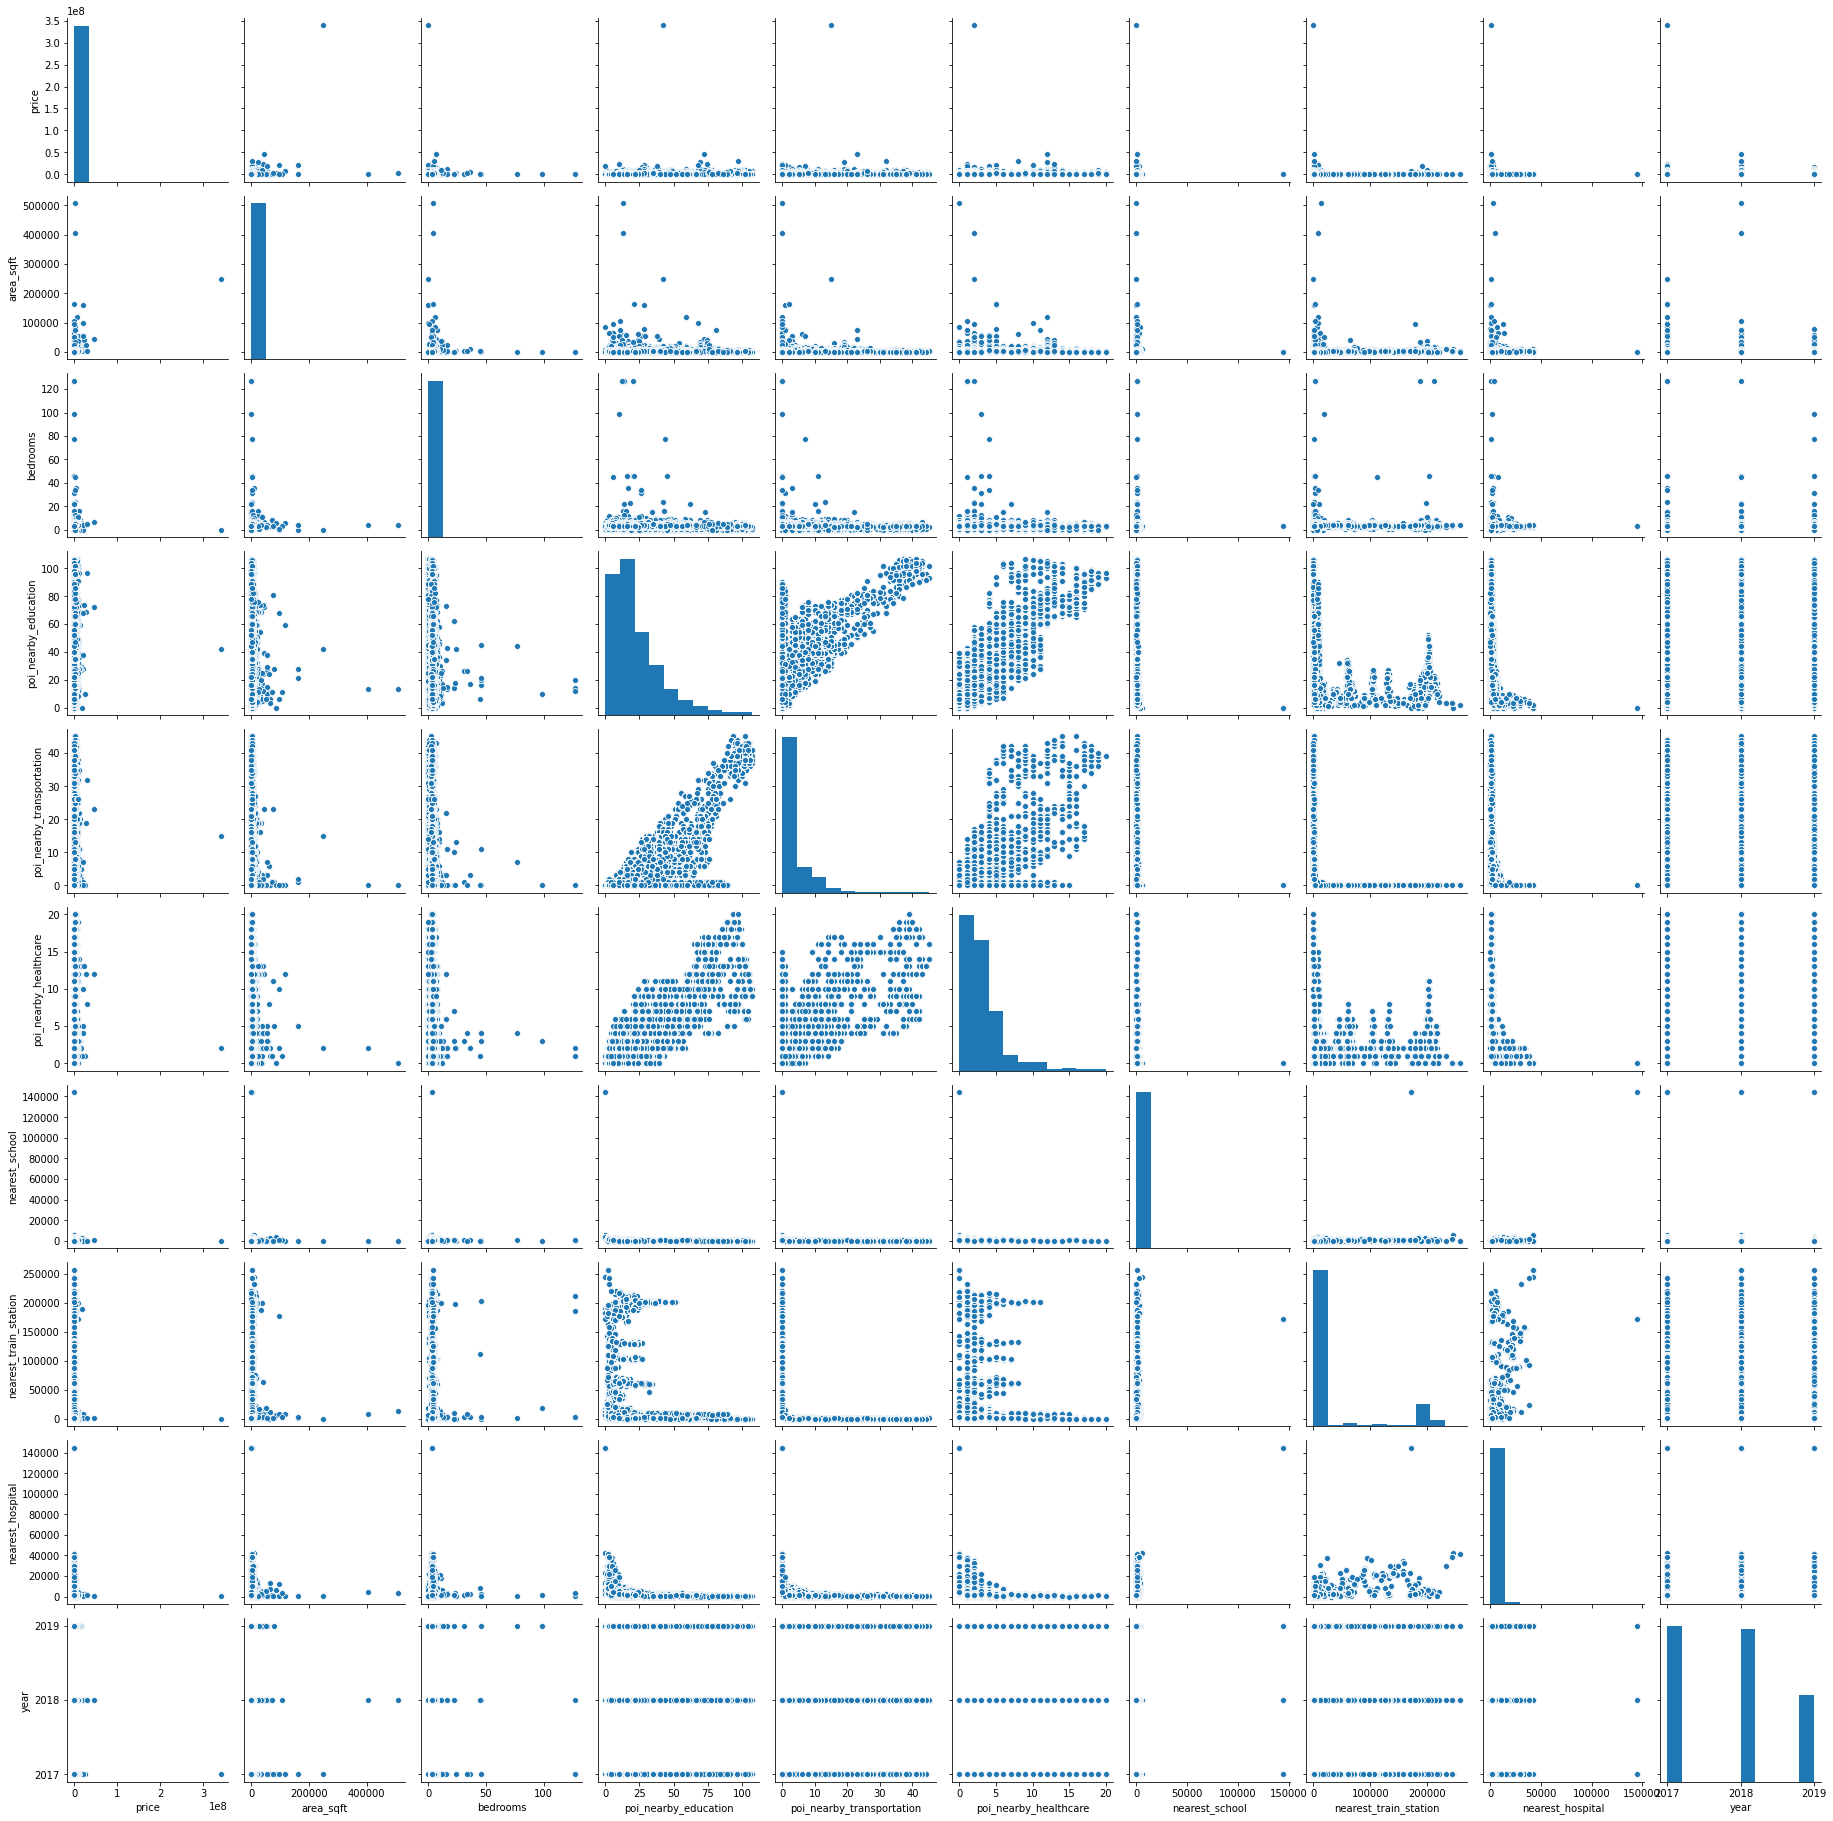

In [18]:
import matplotlib
import seaborn as sns
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

# Remove outliers

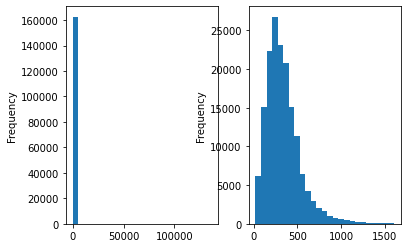

In [19]:

fig, axes = plt.subplots(1, 2)

transactions['psf'].plot.hist('Before', bins=25, ax=axes[0])

# transactions['psf'] = transactions['price']/transactions['area_sqft']
min_psf, max_psf = transactions['psf'].quantile([0.002, 0.998])

# drop if they are outliers
transactions = transactions[
    (transactions['psf'] > min_psf) &
    (transactions['psf'] < max_psf)
]
transactions['psf'].plot.hist('After', bins=25, ax=axes[1])



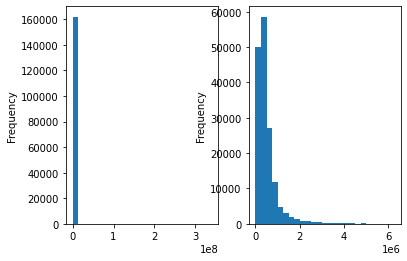

In [20]:
fig, axes = plt.subplots(1, 2)

transactions['price'].plot.hist('Before', bins=25, ax=axes[0])

min_price, max_price = transactions['price'].quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['price'] > min_price) &
    (transactions['price'] < max_price)
]

transactions['price'].plot.hist('After', bins=25, ax=axes[1])



In [21]:
transactions[transactions['price'] > 3000000].sort_values('price', ascending = False)

,project_id,township,property_type,tenure,area_sqft,non_landed,bedrooms,psf,price,planning_region,...,poi_nearby_education,poi_nearby_transportation,poi_nearby_healthcare,nearest_school,nearest_train_station,nearest_hospital,total_poi_nearby,nearest_poi,transaction_count,year
87972,17247,Seputeh Heights,Detached House,Freehold,11248.0,0,5.0,556.276671,6257000,Seputeh,...,46,19,4,744.423492,584.632829,879.234544,69,584.632829,1,2017
12350,16828,Damansara Heights (Bukit Damansara),Detached House,Leasehold,23293.0,0,6.0,268.320955,6250000,Damansara,...,30,2,2,207.992652,183.020607,167.577761,34,167.577761,137,2017
9701,11467,Seri Beringin,Detached House,Freehold,10172.0,0,4.0,614.186001,6247500,Damansara,...,32,4,4,588.851004,1266.836775,1812.300766,40,588.851004,40,2018
132372,10864,Pavilion Residences,Hotel/Service Apartment,Leasehold,4230.0,1,4.0,1468.957447,6213690,Bukit Bintang,...,107,37,10,215.858971,432.558107,897.968321,154,215.858971,41,2017
132373,10864,Pavilion Residences,Hotel/Service Apartment,Leasehold,4230.0,1,2.0,1468.957447,6213690,Bukit Bintang,...,107,37,10,215.858971,432.558107,897.968321,154,215.858971,41,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103885,23620,Taman Dutamas,Semi-Detached House,Freehold,4715.0,0,6.0,638.812301,3012000,Cheras South,...,16,3,4,1025.758748,1295.880929,259.517255,23,259.517255,9,2017
12510,16847,Desa Hill Villas,Semi-Detached House,Freehold,2691.0,0,5.0,1117.971014,3008460,Desa Petaling,...,39,8,3,148.050310,752.608321,2405.002664,50,148.050310,14,2017
23757,9957,Jade Hills,Detached House,Freehold,7729.0,0,6.0,388.640186,3003800,Kajang,...,13,2,1,834.128416,2768.652571,3169.292582,16,834.128416,122,2017
54989,13286,Temasya Glenmarie,Terrace House,Freehold,6168.0,0,3.0,486.997406,3003800,Glenmarie,...,32,11,2,1140.109209,869.788554,1871.229948,45,869.788554,94,2017


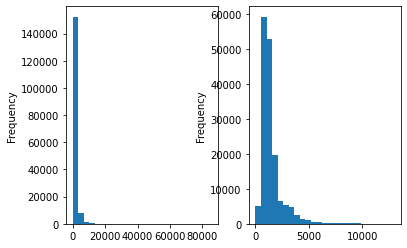

In [22]:
fig, axes = plt.subplots(1, 2)

transactions['area_sqft'].plot.hist('Before', bins=25, ax=axes[0])

min_area, max_area = transactions['area_sqft'].quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['area_sqft'] > min_area) &
    (transactions['area_sqft'] < max_area)
]

transactions['area_sqft'].plot.hist('After', bins=25, ax=axes[1])

In [23]:
transactions['bedrooms'].max()

127.0

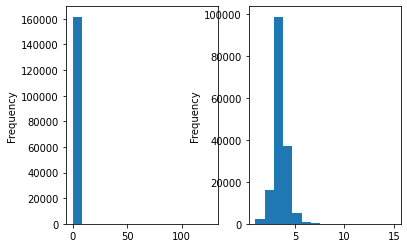

In [24]:
fig, axes = plt.subplots(1, 2)

transactions['bedrooms'].plot.hist('Before', bins=15, ax=axes[0])

min_bedroom, max_bedroom = transactions['bedrooms'].astype(int).quantile([0.00, 0.9998])

# drop if they are outliers
transactions = transactions[
    (transactions['bedrooms'] > min_bedroom) &
    (transactions['bedrooms'] < max_bedroom)
]

transactions['bedrooms'].plot.hist('After', bins=15, ax=axes[1])

In [25]:
transactions[transactions['bedrooms'] > 10].sort_values('bedrooms', ascending = False)

,project_id,township,property_type,tenure,area_sqft,non_landed,bedrooms,psf,price,planning_region,...,poi_nearby_education,poi_nearby_transportation,poi_nearby_healthcare,nearest_school,nearest_train_station,nearest_hospital,total_poi_nearby,nearest_poi,transaction_count,year
70778,16912,PKNS Ulu Kelang,Flat,Leasehold,872.0,1,15.0,298.165138,260000,Taman Setiawangsa,...,34,3,6,408.303697,1972.499318,2101.376740,43,408.303697,221,2017
70806,16912,PKNS Ulu Kelang,Flat,Leasehold,872.0,1,15.0,344.036697,300000,Taman Setiawangsa,...,34,3,6,408.303697,1972.499318,2101.376740,43,408.303697,221,2017
102537,23187,Taman Desa Meringin,Detached House,Freehold,7180.0,0,13.0,222.841226,1600000,Kajang,...,14,0,3,236.313441,3224.135508,2508.828605,17,236.313441,5,2019
25066,10584,Minden Heights,Detached House,Freehold,4542.0,0,12.0,308.234258,1400000,Minden Heights,...,16,0,2,152.691591,7556.682756,2853.723531,18,152.691591,33,2018
48337,12891,Taman Selayang Baru,Detached House,Leasehold,4004.0,0,12.0,234.765235,940000,Selayang,...,26,1,3,672.571963,2799.775082,1485.802520,30,672.571963,67,2019
90711,12435,"Kampung Permata, Rawang",Detached House,Leasehold,3961.0,0,12.0,70.689220,280000,Rawang,...,3,0,1,280.570755,3818.477484,6663.669954,4,280.570755,1,2017
18484,16251,Seri Bestari Apartments,Flat,Leasehold,958.0,1,11.0,114.822547,110000,Kerling,...,9,1,2,875.200283,2015.885269,17953.637157,12,875.200283,29,2017


In [26]:
# makes the outliers make sense except the two flats with 15 room, manually remove
transactions = transactions[transactions['bedrooms'] < 15]

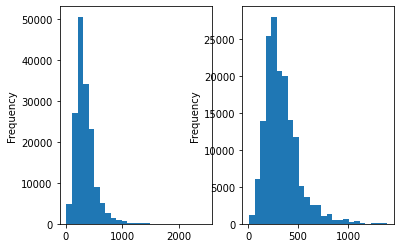

In [27]:
fig, axes = plt.subplots(1, 2)

transactions['median_psf'].plot.hist('Before', bins=25, ax=axes[0])

min_median_psf, max_median_psf = transactions['median_psf'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['median_psf'] > min_median_psf) &
    (transactions['median_psf'] < max_median_psf)
]

transactions['median_psf'].plot.hist('After', bins=25, ax=axes[1])

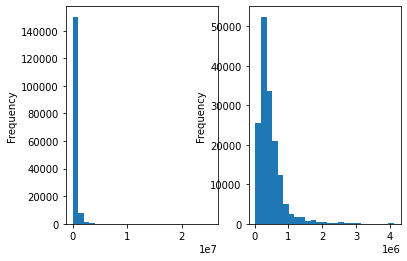

In [28]:
fig, axes = plt.subplots(1, 2)

transactions['median_price'].plot.hist('Before', bins=25, ax=axes[0])

min_median_price, max_median_price = transactions['median_price'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['median_price'] > min_median_price) &
    (transactions['median_price'] < max_median_price)
]

transactions['median_price'].plot.hist('After', bins=25, ax=axes[1])

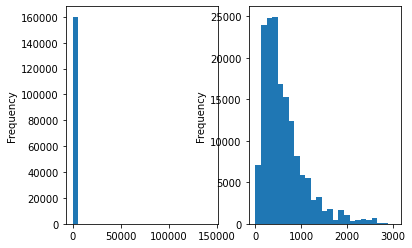

In [29]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_poi'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_poi'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_poi'] > min_nearest_poi) &
    (transactions['nearest_poi'] < max_nearest_poi)
]

transactions['nearest_poi'].plot.hist('After', bins=25, ax=axes[1])

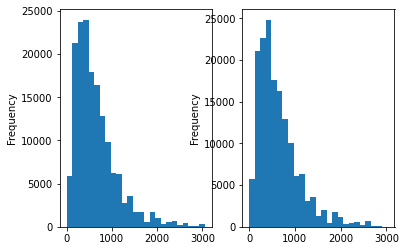

In [30]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_school'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_school'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_school'] > min_nearest_poi) &
    (transactions['nearest_school'] < max_nearest_poi)
]

transactions['nearest_school'].plot.hist('After', bins=25, ax=axes[1])

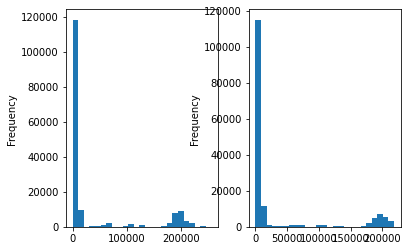

In [31]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_train_station'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_train_station'].astype(int).quantile([0.00, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_train_station'] > min_nearest_poi) &
    (transactions['nearest_train_station'] < max_nearest_poi)
]

transactions['nearest_train_station'].plot.hist('After', bins=25, ax=axes[1])

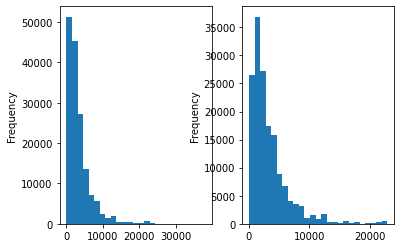

In [32]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_hospital'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_hospital'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_hospital'] > min_nearest_poi) &
    (transactions['nearest_hospital'] < max_nearest_poi)
]

transactions['nearest_hospital'].plot.hist('After', bins=25, ax=axes[1])

In [33]:
transactions['property_type'].value_counts()

Terrace House              66494
Condominium/Apartment      38804
Flat                       27544
Semi-Detached House         8408
Hotel/Service Apartment     6591
Detached House              3972
Cluster House               2205
Low-Cost House              1987
Town House                  1867
Name: property_type, dtype: int64

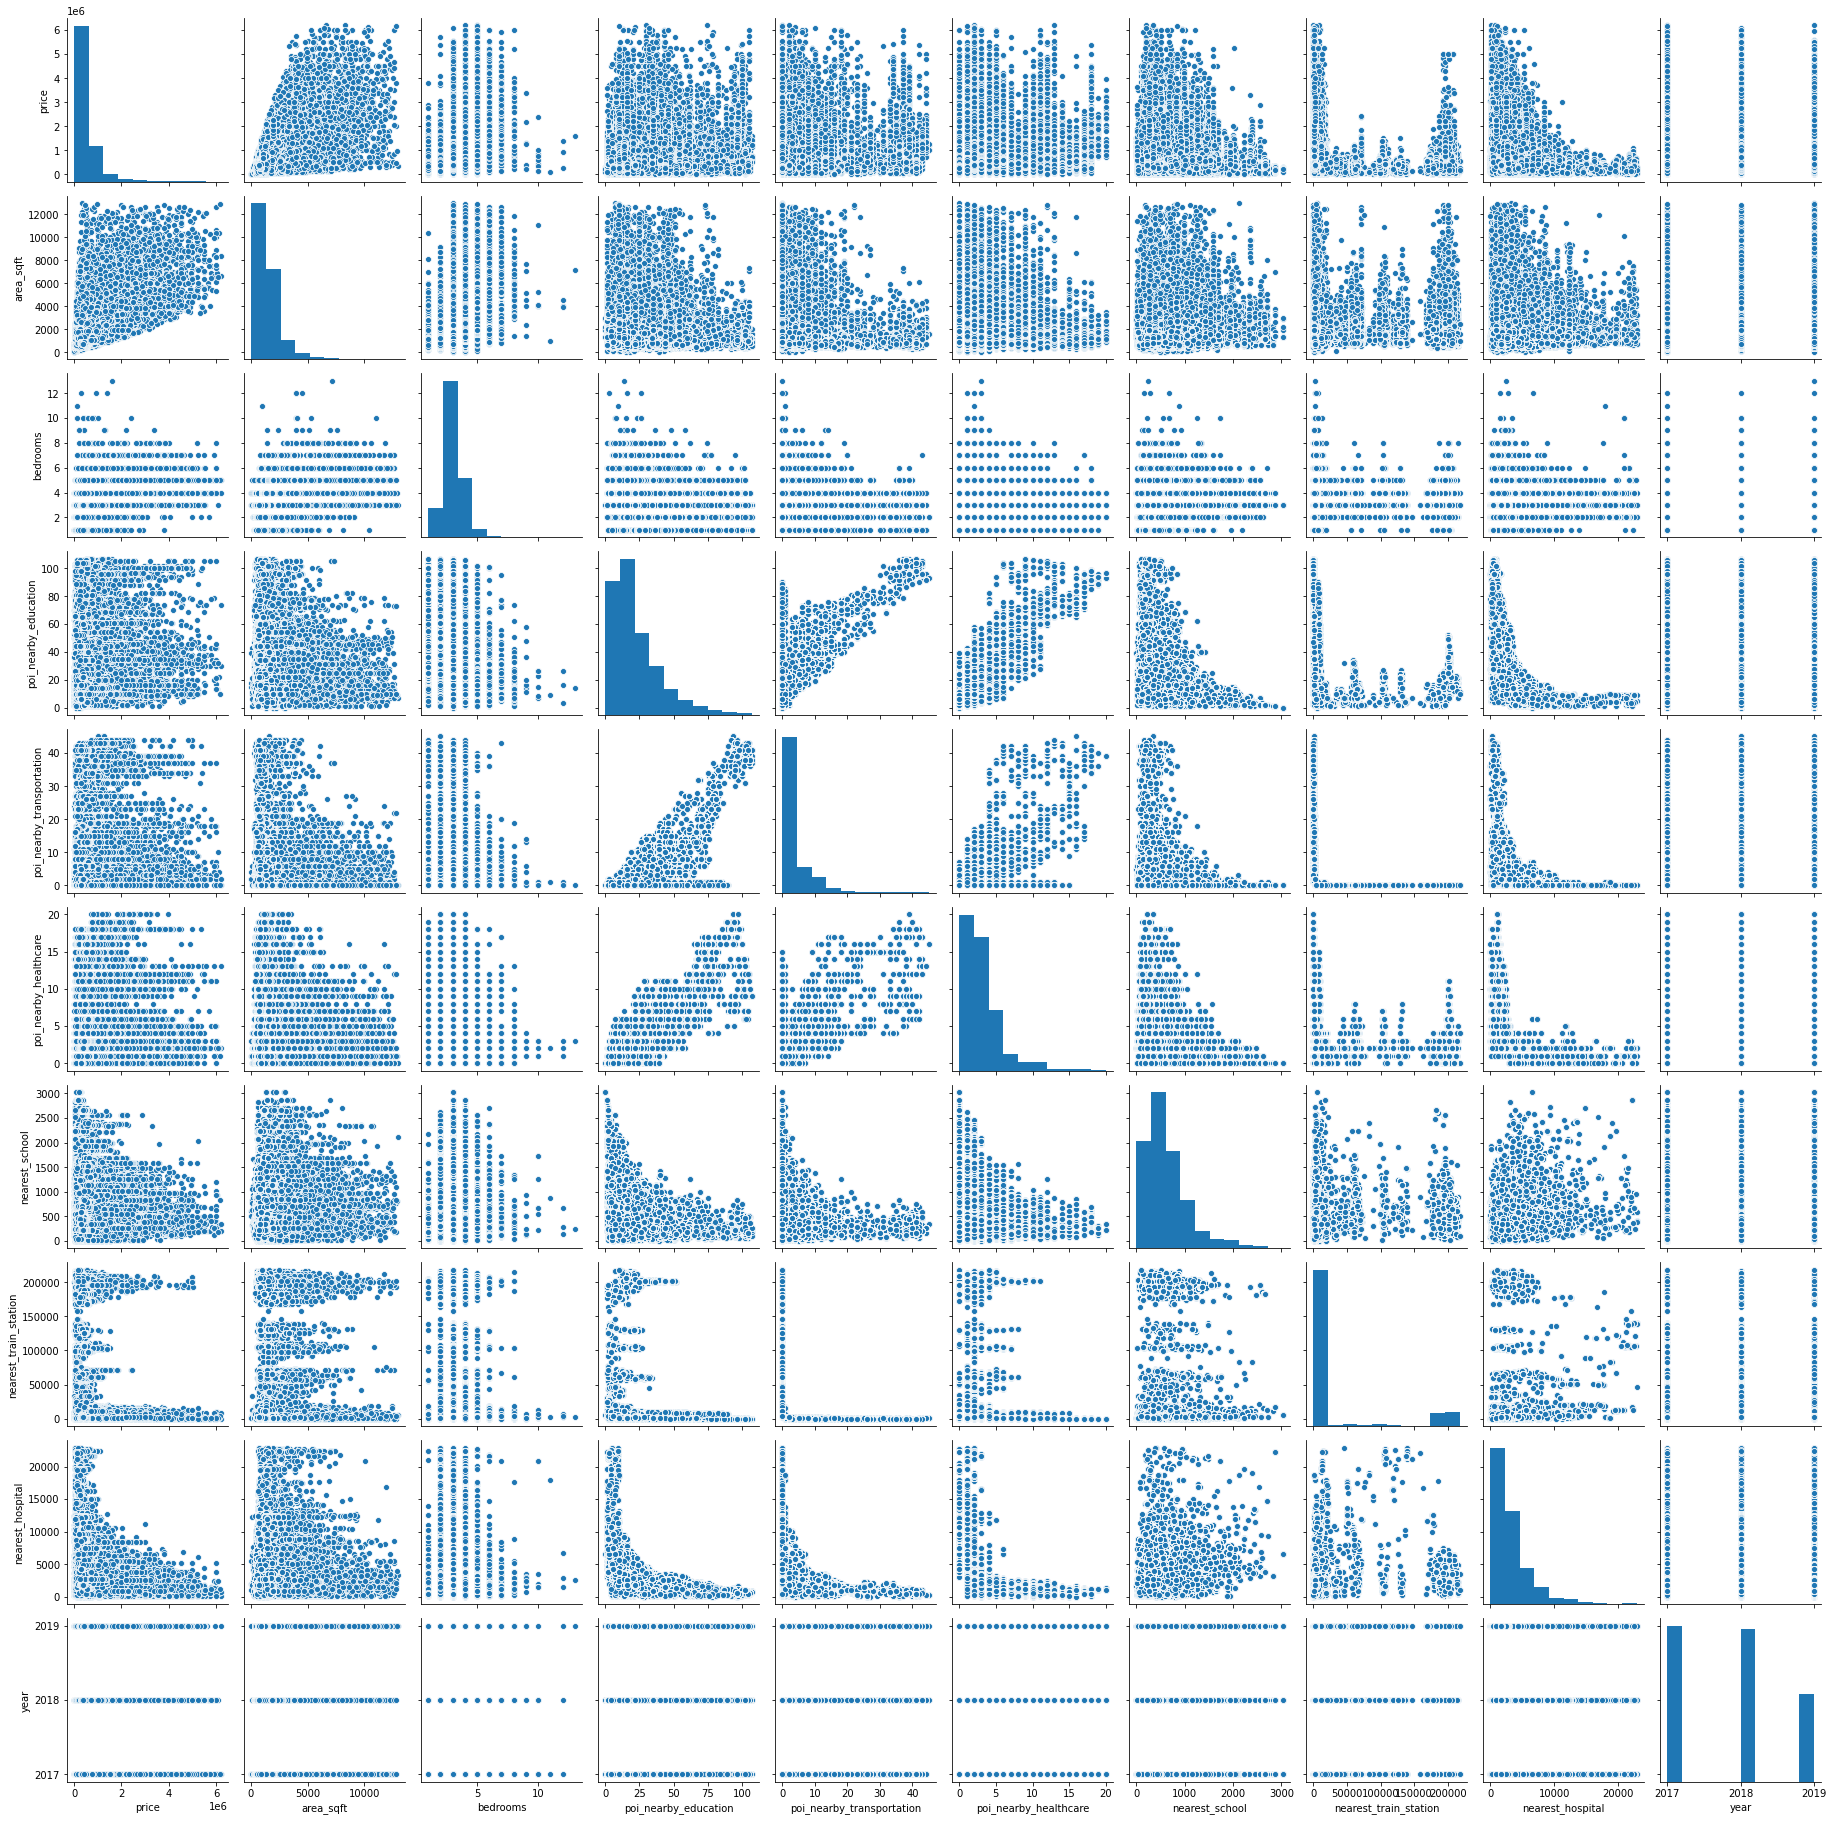

In [34]:
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

In [35]:
transactions.shape

(157872, 24)

In [36]:
transactions.to_csv(transaction_csv)

In [37]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157872 entries, 0 to 173217
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   project_id                 157872 non-null  int64  
 1   township                   157872 non-null  object 
 2   property_type              157872 non-null  object 
 3   tenure                     157872 non-null  object 
 4   area_sqft                  157872 non-null  float64
 5   non_landed                 157872 non-null  int64  
 6   bedrooms                   157872 non-null  float64
 7   psf                        157872 non-null  float64
 8   price                      157872 non-null  int64  
 9   planning_region            157872 non-null  object 
 10  state                      157872 non-null  object 
 11  city                       157872 non-null  object 
 12  median_psf                 157872 non-null  float64
 13  median_price               15